In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pickle
import os
import json
import numpy as np
import random
#from PIL import Image
import torch
import matplotlib.pyplot as plt

from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import sampler
import torch.nn.functional as F

from skimage.transform import resize
from skimage import io, transform, util
from scipy.signal import argrelextrema
from sklearn.metrics import pairwise_distances
from operator import itemgetter
from skimage.filters import threshold_mean


from skimage.util import img_as_uint #crop
from skimage.color import rgb2gray
import sys

from scipy.stats import ks_2samp, anderson_ksamp

from keras.models import load_model
import h5py
import matplotlib.pyplot as plt

device = torch.device('cuda') #torch.cuda.get_device_name(0)
dtype = torch.float32



In [ ]:
!pip install python-levenshtein
from Levenshtein import distance as levenshtein_distance

     |████████████████████████████████| 51kB 3.7MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.0-cp36-cp36m-linux_x86_64.whl size=144799 sha256=2cd336831b467a409ddb2733c1f59674b1683b10d0dfb5ee9a67bb3db570a209
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-levenshtein


In [ ]:
!unzip '/gdrive/My Drive/datasets/prima-newspaper.zip'

pkl_file = open('lines_list_all.pkl', 'rb')
lines_list_all = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('ground_truth_all.pkl', 'rb')
ground_truth = pickle.load(pkl_file)
pkl_file.close()

Archive:  /gdrive/My Drive/datasets/prima-newspaper.zip
  inflating: ground_truth_all.pkl    
  inflating: lines_list_all.pkl      


Now, as what we buy becomes our own, I am ready


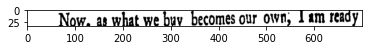

It is well known to the World, that, when a certain


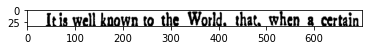

Now, whether the War with Spain was a right, or a


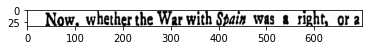

on a Letter wrote by the Province of Utrecht to the States


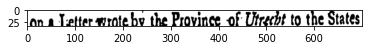

Monday Admiral Vernon took the Oaths and his Seat


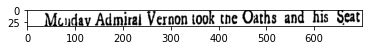

General Wentworth is gone down to Witchurch in


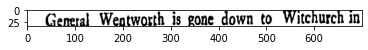

We have Advice, that the Burford Man of War, Capt.


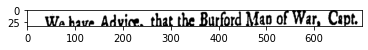

They write from St. Kitts, of the 30th of December,


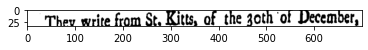

that the Privateer belonging to Mr. Rowland, a Merchant


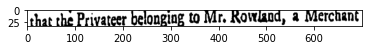

Some People having alledged that Night Marriages are


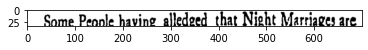

We are told, that the Court of France has lately given


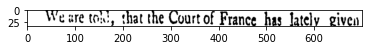

Letters from Ghent in Flanders mention, that a Spotted


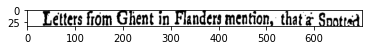

A Treaty of Marriage is concluded between his Royal


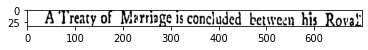

Accounts from Ireland represent the disease in


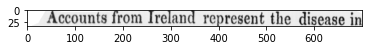

the potato crop as prevalent there as in this


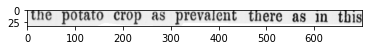

country.


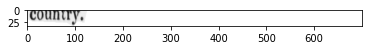

The inauguration of the statue of Jean Bart, the


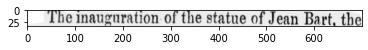

famous sea captain in the time of Louis XIV, took


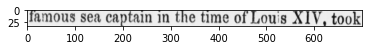

place at Dunkirk, his native town, on Sunday last,


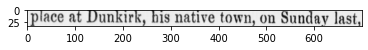

with great ceremony and splendour. The statue,


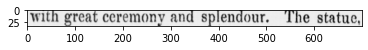

which is of bronze and of colossal size, is erected


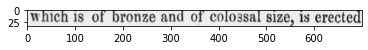

in the great square of the town.


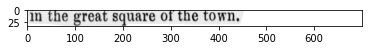

By the arrival of a vessel at Falmouth from


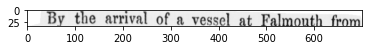

Buenos Ayres, with papers from the River Plate


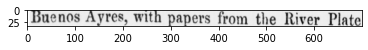

In [ ]:
label_map = {'(': 0, ')': 1, ',': 2, '.' :3, '-': 4, '/': 5, '<': 6, ' ':7}
for i in range(10):
    label_map[chr(48+i)] = 8+i
for i in range(26):
    label_map[chr(65+i)] = 18+i
for i in range(26):
    label_map[chr(97+i)] = 44+i

class SegmentaionMidv500(Dataset):

    def __init__(self, transform=None): #process -> resize or append
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # self.root_dir = root_dir        
        self.transform = transform
        self.sample_list = []
        for xml_file in lines_list_all:
            for reg in lines_list_all[xml_file]:
              if len(lines_list_all[xml_file][reg]) != len(ground_truth[xml_file][reg]):
                continue
              
              line_ = 0
              for line in lines_list_all[xml_file][reg]:
                  flag=0
                  for c in ground_truth[xml_file][reg][line_]:
                    if c not in label_map:
                      flag = 1
                      break
                  if flag ==1:
                    continue
                  line = img_as_uint(line)
                  if line.shape[0]>33:
                    line_new = resize(line[int(line.shape[0]/2)-16: int(line.shape[0]/2)+16], (33,700))
                  else:
                    line_new = resize(line, (33,700))
                  print(ground_truth[xml_file][reg][line_])
                  plt.figure()
                  plt.imshow(line_new, cmap='gray')
                  plt.show()
                  sample = {}
                  sample['image'] = line_new.reshape(1,33,700)
                  sample['landmark'] = -1
                  sample['value'] = ground_truth[xml_file][reg][line_]
                  # word_list_dict[ind] = [xml_file, reg, line_]
                  self.sample_list.append(sample)
                  line_ += 1



    def __len__(self):
        return len(self.sample_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.transform:
            for item in range(len(self.sample_list)):
                self.sample_list[item] = self.transform(self.sample_list[item])
        return self.sample_list[idx]


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks, val = sample['image'], sample['landmark'], sample['value']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        #image = image.transpose((2, 0, 1))
        if not torch.is_tensor(image):
            image = torch.from_numpy(image)
        if not torch.is_tensor(landmarks):
            landmarks = torch.tensor(landmarks)
        return {'image': image,
                'landmark': landmarks, 'value': val}

test_dataset = SegmentaionMidv500(transform=transforms.Compose([ToTensor()]))

In [ ]:
loader_test = DataLoader(test_dataset,batch_size = len(test_dataset))

In [ ]:
len(test_dataset)

24

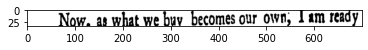

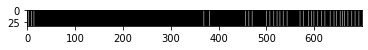

Now, as what we buy becomes our own, I am ready -> 
Now, as what we buy becomes our own, I am ready -> 
Now, as what we buy becomes our own, I am ready ->                                       


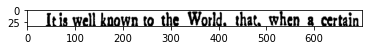

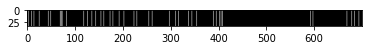

It is well known to the World, that, when a certain -> 
It is well known to the World, that, when a certain -> 
It is well known to the World, that, when a certain ->                                       


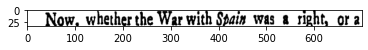

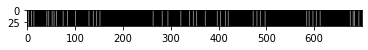

Now, whether the War with Spain was a right, or a -> 
Now, whether the War with Spain was a right, or a -> 
Now, whether the War with Spain was a right, or a ->                                       


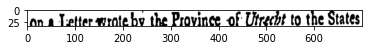

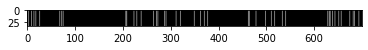

on a Letter wrote by the Province of Utrecht to the States -> 
on a Letter wrote by the Province of Utrecht to the States -> 
on a Letter wrote by the Province of Utrecht to the States ->                                       


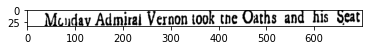

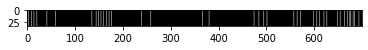

Monday Admiral Vernon took the Oaths and his Seat -> 
Monday Admiral Vernon took the Oaths and his Seat -> 
Monday Admiral Vernon took the Oaths and his Seat ->                                       


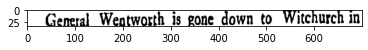

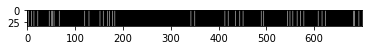

General Wentworth is gone down to Witchurch in -> 
General Wentworth is gone down to Witchurch in -> 
General Wentworth is gone down to Witchurch in ->                                       


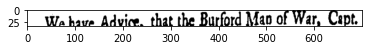

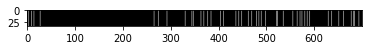

We have Advice, that the Burford Man of War, Capt. -> 
We have Advice, that the Burford Man of War, Capt. -> 
We have Advice, that the Burford Man of War, Capt. ->                                       


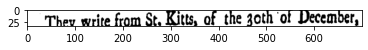

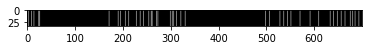

They write from St. Kitts, of the 30th of December, -> 
They write from St. Kitts, of the 30th of December, -> 
They write from St. Kitts, of the 30th of December, ->                                       


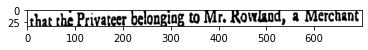

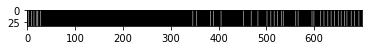

that the Privateer belonging to Mr. Rowland, a Merchant -> 
that the Privateer belonging to Mr. Rowland, a Merchant -> 
that the Privateer belonging to Mr. Rowland, a Merchant ->                                       


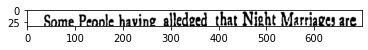

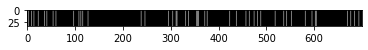

Some People having alledged that Night Marriages are -> 
Some People having alledged that Night Marriages are -> 
Some People having alledged that Night Marriages are ->                                       


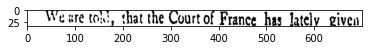

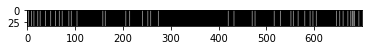

We are told, that the Court of France has lately given -> 
We are told, that the Court of France has lately given -> 
We are told, that the Court of France has lately given ->                                       


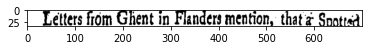

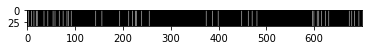

Letters from Ghent in Flanders mention, that a Spotted -> 
Letters from Ghent in Flanders mention, that a Spotted -> 
Letters from Ghent in Flanders mention, that a Spotted ->                                       


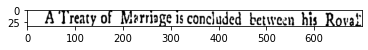

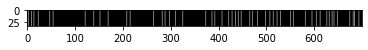

A Treaty of Marriage is concluded between his Royal -> 
A Treaty of Marriage is concluded between his Royal -> 
A Treaty of Marriage is concluded between his Royal ->                                       


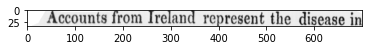

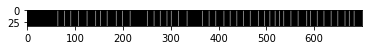

Accounts from Ireland represent the disease in -> ccountroIrcanrepresentthaiseasci
Accounts from Ireland represent the disease in -> ccountsroIrclanrepresentthcaiseasci
Accounts from Ireland represent the disease in -> ccountsroIrclanrepresent t)hcaiseascIi


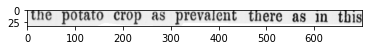

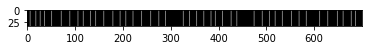

the potato crop as prevalent there as in this -> t1hicptaocoPaseva1ntherasntbi
the potato crop as prevalent there as in this -> t1hicpotaocroPasreva1cnthereasntbi
the potato crop as prevalent there as in this -> t1hicpota1o croP asreva1cnthere asntbi


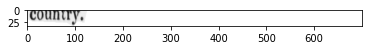

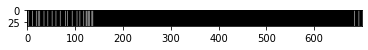

country. -> xc )onuiuhiV r3yr.77
country. -> xc )o)nuiuzhilV r3yr i.77-
country. -> xc )koO)nAuiuzhilV tr3yr i.77-        


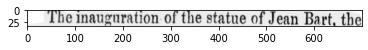

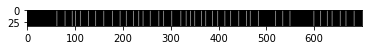

The inauguration of the statue of Jean Bart, the -> hjinauguratonofth1estatueoaarth
The inauguration of the statue of Jean Bart, the -> hejinauguratonoft1h1estatueoaartVh
The inauguration of the statue of Jean Bart, the -> hejinauguraton oft1h1e statue oeaartVh


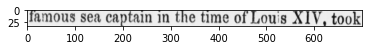

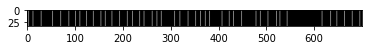

famous sea captain in the time of Louis XIV, took -> 1aousseacaptainjithetuieo,oujtok
famous sea captain in the time of Louis XIV, took -> 1aousseacaptainjithetuieo,ouj4took
famous sea captain in the time of Louis XIV, took -> 1aous seacaptainjithe tuie o,ouj4Qtook


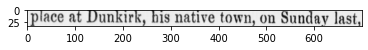

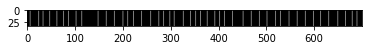

place at Dunkirk, his native town, on Sunday last, -> p1aceatunkirkisativetonnundaast
place at Dunkirk, his native town, on Sunday last, -> p1aceatunkirkhisnativetononSundaast
place at Dunkirk, his native town, on Sunday last, -> p1ace atunkirkhisnative tononSundaJast


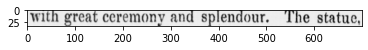

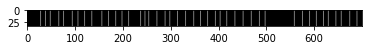

with great ceremony and splendour. The statue, -> greacrezo,nyandspendouhesttue
with great ceremony and splendour. The statue, -> itgreacerezo,nyandsp1endourhesttue
with great ceremony and splendour. The statue, -> it greacerezo,ny and sp1endourhe sttue


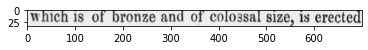

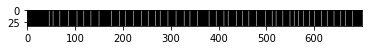

which is of bronze and of colossal size, is erected -> icjsobrnzeandoco1ossaize jiserecte
which is of bronze and of colossal size, is erected -> icjsobronzeandoco1ossaTize jiserecte
which is of bronze and of colossal size, is erected -> icjsobronze andoco1ossaTize jis erecte


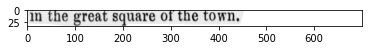

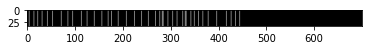

in the great square of the town. -> 1thgratsquaro5fthto.
in the great square of the town. -> 1mthegrvatsquareo55fthiiketoni.
in the great square of the town. -> 1lm the grvat square o55Ifthiike toni.


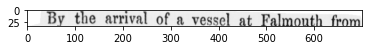

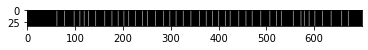

By the arrival of a vessel at Falmouth from -> yt1earrivaofavesspA1ww5
By the arrival of a vessel at Falmouth from -> yth1earrivaiofavessc1apA1ow,zw5
By the arrival of a vessel at Falmouth from -> yth1e arrivai of avessc1ai pA1o,w,zw 5


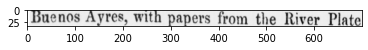

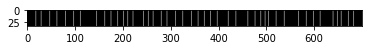

Buenos Ayres, with papers from the River Plate -> 5uenosyres,ithpaperst1h,cvrIa1
Buenos Ayres, with papers from the River Plate -> 5uenosyres,ithpapers0t1h,cverIa1
Buenos Ayres, with papers from the River Plate -> 5uenosyres, ith papers 0 t1h,c ver4Ia1


In [ ]:
def my_custom_euclidean(x, y):
    return torch.mean(torch.sqrt(torch.sum(torch.square(x-y), dim=-1)))

class CustomActivation(nn.Module):
    def __init__(self, mean=0, std=1, _min=0.0, _max=1.0):
        super(CustomActivation, self).__init__()
        self.mean = mean
        self.std = std
        self.min = _min
        self.max = _max
        
    def forward(self, x):
        gauss = torch.exp((-(x - self.mean)**2)/(2*self.std**2))
        return torch.clamp(gauss, min=self.min, max=self.max)
    
class CustomActivation_inverse_quadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_inverse_quadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return 1/(1 + (self.epsilon*x)**2)
    
class CustomActivation_multiquadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_multiquadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return torch.sqrt(1 + (self.epsilon*x)**2)
    
class CustomActivation_inverse_multiquadratic(nn.Module):
    def __init__(self, epsilon=1):
        super(CustomActivation_inverse_multiquadratic, self).__init__()
        self.epsilon = epsilon
        
    def forward(self, x):
        return 1/torch.sqrt(1 + (self.epsilon*x)**2)
    
def check_accuracy_part34(loader, model):   
    num_correct = 0
    num_samples = 0
    total_loss = []
    orig_ks_loss = [[], []]
    ks_loss = [[], []]
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, x_y in enumerate(loader):
            x = x_y['image']
            y = x_y['landmark']
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
#             loss = torch.dist(scores, y)
#             total_loss.append(loss.item())
            loss = my_custom_euclidean(scores,y)
            total_loss.append(float(loss))
            
    print('train/val loss = %.4f' % (np.mean(np.asarray(total_loss))))
        
               
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

classifier = load_model("classifierpaper_70classes-2-95.34.h5")
model = torch.load("/content/segmenter_gaussian_mse_relu_700.h5")
model.eval()

pkl_file = open('/gdrive/My Drive/datasets/fd.pkl', 'rb')
fd = pickle.load(pkl_file)
pkl_file.close()

# pkl_file = open('custom_w_h.pkl', 'rb')
# custom_w_h = pickle.load(pkl_file)
# pkl_file.close()

fd_min, fd_max, fd_mean, w_h_min, w_h_max, w_h_mean = fd['fd_min'], fd['fd_max'], fd['fd_mean'], fd['w_h_min'], fd['w_h_max'], fd['w_h_mean']


dist_list = []
dist1_list = []
len_list = []
dist_list2 = []
dist1_list2 = []
len_list2 = []
dist_list3 = []
dist1_list3 = []
len_list3 = []
#predict cuts
with torch.no_grad():
    for t, x_y in enumerate(loader_test):
        x = x_y['image']
        y = x_y['landmark']
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.int16)
        char_val = x_y['value']
        scores_test = model(x)
batch_size, _, ht, wd = x.size()
#convert to numpy
scores_temp = scores_test.cpu().detach().numpy()
scores_temp = scores_temp.reshape((batch_size, -1))

images = x.detach().cpu().detach().numpy()
images = images.reshape((batch_size,ht,wd))

for i in range(batch_size):
    # if i == 1:
    #   break
    image_example = images[i]
    score_example = scores_temp[i]
    plt.figure()
    plt.imshow(image_example, cmap='gray')
    plt.show()
    # orig str
    # char_list = char_list_dict[int(char_val[i])]
    # char_str = ''
    # for c in char_list:
    #     char_str += c
    if y[i] == -1:
      char_str = char_val[i]
    else:
      char_str=''
      for _ in range(y[i]):
        char_str += char_val[i]

    #local maxima indices
    index_P = argrelextrema(score_example, np.greater)[0] #index of local maxima
    index_P_01 = np.zeros(score_example.shape) 
    index_P_01[index_P] = 1 


    #dist between left and right index of cuts
    #len(index_P)xlen(index_P)
    dist = pairwise_distances(np.asarray(index_P).reshape(-1,1), metric='manhattan') 
    #index pairs such that width is betwwen fd-min and fd-max
    l, r = np.where((dist>= np.min(fd_min)) & (dist<= np.min(fd_max)))
    # l, r = np.where((dist>= np.min(custom_w_h)) & (dist<= np.max(custom_w_h)))
    # l, r = np.where((dist/33>= np.min(w_h_min)) & (dist/33<= np.min(w_h_max)))
    #top m = img_width/mean_char_width choices
    l_r = []

    for j in range(len(l)):
        if l[j] < r[j]: #and (index_P[int(r[j])] - index_P[int(l[j])])/33 >= np.mean(w_h_min) and (index_P[int(r[j])] - index_P[int(l[j])])/33 <= np.mean(w_h_max):
            try:
                l_r.append([ index_P[int(l[j])], index_P[int(r[j])], 
                                     score_example[index_P[int(l[j])]] + score_example[index_P[int(r[j])]] ])
            except TypeError:
                print("AAH", l[j], r[j], len(index_P), )

    # l_r = l_r[l_r[:,2].argsort()] #sort according to P(l) +P(r)
    l_r_sorted = sorted(l_r, key = itemgetter(2), reverse=True)

    char_images = []
    segment_list = np.zeros((33,700))
    #top m choices
    for _i in range(len(l_r)): # #np.mean(fd_mean))):
        if l_r[_i] in l_r_sorted[0:int(700/np.mean(fd_mean))]:
            img_crop = image_example[:, l_r[_i][0]: l_r[_i][1]]
            img_bin = resize(img_crop, (15,19))
            char_images.append(img_bin)
            segment_list[:, l_r[_i][0]] = 255
            segment_list[:, l_r[_i][1]] = 255
    plt.figure()
    plt.imshow(segment_list, cmap='gray')
    plt.show()
    
    if len(char_images) == 0:
      continue
    X_test = np.asarray(char_images)
    X_test = X_test.reshape((X_test.shape[0], 15, 19, 1))
    class_probs = np.asarray(classifier.predict(X_test))
    max_scores = np.max(class_probs, axis=1)
    max_scores_index = np.argmax(class_probs, axis=1)
    output_str = ''
    for _i in range(len(max_scores_index)):
        # if max_scores[_i] < 0.75:
        #   continue
        s = max_scores_index[_i]
        for k, v in label_map.items():
            if v == s:
                output_str += k
    print(char_str, "->", output_str)
    dist_list.append(levenshtein_distance(output_str, char_str))
    dist1_list.append(levenshtein_distance(output_str, char_str) * len(char_str))
    len_list.append(len(char_str))

    output_str = ''
    for _i in range(len(max_scores_index)):
        if max_scores[_i] < 0.5:
          continue
        s = max_scores_index[_i]
        for k, v in label_map.items():
            if v == s:
                output_str += k
    print(char_str, "->", output_str)
    dist_list2.append(levenshtein_distance(output_str, char_str))
    dist1_list2.append(levenshtein_distance(output_str, char_str) * len(char_str))
    len_list2.append(len(char_str))

    output_str = ''
    for _i in range(len(max_scores_index)):
        if max_scores[_i] < 0.75:
          continue
        s = max_scores_index[_i]
        for k, v in label_map.items():
            if v == s:
                output_str += k
    print(char_str, "->", output_str)
    dist_list3.append(levenshtein_distance(output_str, char_str))
    dist1_list3.append(levenshtein_distance(output_str, char_str) * len(char_str))
    len_list3.append(len(char_str))



In [ ]:
PCR = 0
for i in range(len(dist_list)):
  PCR += min(dist_list[i], len_list[i])
PCR /= sum(len_list)
PCR = (1 - PCR) * 100

print(PCR) #test-data
print(np.mean(dist_list))
print(np.sum([dist_list[i] * len_list[i] for i in range(len(dist_list))])/ np.sum(len_list))

PCR = 0
for i in range(len(dist_list2)):
  PCR += min(dist_list2[i], len_list2[i])
PCR /= sum(len_list2)
PCR = (1 - PCR) * 100

print("keep prob 0.5")
print(PCR) #test-data
print(np.mean(dist_list2))
print(np.sum([dist_list2[i] * len_list2[i] for i in range(len(dist_list2))])/ np.sum(len_list2))

PCR = 0
for i in range(len(dist_list3)):
  PCR += min(dist_list3[i], len_list3[i])
PCR /= sum(len_list3)
PCR = (1 - PCR) * 100
print("keep prob 0.75")
print(PCR) #test-data
print(np.mean(dist_list3))
print(np.sum([dist_list3[i] * len_list3[i] for i in range(len(dist_list3))])/ np.sum(len_list3))

21.83908045977011
37.083333333333336
38.95755968169761
keep prob 0.5
23.43059239610964
36.583333333333336
38.243147656940764
keep prob 0.75
36.162687886825815
31.041666666666668
31.93103448275862
